In [1]:
from google.colab import files

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d sobhanmoosavi/us-accidents

Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
 97% 633M/653M [00:01<00:00, 284MB/s]
100% 653M/653M [00:01<00:00, 379MB/s]


In [4]:
!unzip us-accidents.zip

Archive:  us-accidents.zip
  inflating: US_Accidents_March23.csv  


In [5]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 597 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (597/597), 196.59 KiB | 17.87 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 175 packages in 4.54s
 Downloaded cuproj-cu12
 Downloaded rmm-cu12
 Downloaded shapely
 Downloaded libkvikio-cu12
 Downloaded ucx-py-cu12
 Downloaded datashader
 Downloaded pylibcugraph-cu12
 Downloaded dask
 Downloaded cugraph-cu12
 Downloaded bokeh
 Downloaded cuspatial-cu12
 Downloaded cudf-cu12
 Downloaded librmm-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded nvidia-nvcomp-cu12
 Downloaded libraft-cu12
 Downloaded libcudf-cu12
 Downloaded raft-dask-cu12
 Downloaded 

In [6]:
import cudf         # pandas
import cupy as cp   # numpy
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = cudf.read_csv('/content/US_Accidents_March23.csv')
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype
---  ------                 -----
 0   ID                     object
 1   Source                 object
 2   Severity               int64
 3   Start_Time             object
 4   End_Time               object
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object
 11  Street                 object
 12  City                   object
 13  County                 object
 14  State                  object
 15  Zipcode                object
 16  Country                object
 17  Timezone               object
 18  Airport_Code           object
 19  Weather_Timestamp      object
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)            float64
 23  

In [8]:
# dropping useless columns
cols_to_drop = ['ID', 'Airport_Code', 'Zipcode', 'County']
df.drop(columns=cols_to_drop, inplace=True)

df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 42 columns):
 #   Column                 Dtype
---  ------                 -----
 0   Source                 object
 1   Severity               int64
 2   Start_Time             object
 3   End_Time               object
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object
 10  Street                 object
 11  City                   object
 12  State                  object
 13  Country                object
 14  Timezone               object
 15  Weather_Timestamp      object
 16  Temperature(F)         float64
 17  Wind_Chill(F)          float64
 18  Humidity(%)            float64
 19  Pressure(in)           float64
 20  Visibility(mi)         float64
 21  Wind_Direction         object
 22  Wind_Speed(mph)        float64
 2

In [9]:
print(cp.unique(df.Severity))

df['Severity'] = df['Severity'].astype('uint8')
df.info()

[1 2 3 4]
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 3968473 entries, 0 to 3968472
Data columns (total 42 columns):
 #   Column                 Dtype
---  ------                 -----
 0   Source                 object
 1   Severity               uint8
 2   Start_Time             object
 3   End_Time               object
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object
 10  Street                 object
 11  City                   object
 12  State                  object
 13  Country                object
 14  Timezone               object
 15  Weather_Timestamp      object
 16  Temperature(F)         float64
 17  Wind_Chill(F)          float64
 18  Humidity(%)            float64
 19  Pressure(in)           float64
 20  Visibility(mi)         float64
 21  Wind_Direction         object
 22  Wind_Speed(mph)        

In [9]:
float_cols = df.select_dtypes(include='float64').columns
df[float_cols] = df[float_cols].astype('float32')

df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 42 columns):
 #   Column                 Dtype
---  ------                 -----
 0   Source                 object
 1   Severity               int64
 2   Start_Time             object
 3   End_Time               object
 4   Start_Lat              float32
 5   Start_Lng              float32
 6   End_Lat                float32
 7   End_Lng                float32
 8   Distance(mi)           float32
 9   Description            object
 10  Street                 object
 11  City                   object
 12  State                  object
 13  Country                object
 14  Timezone               object
 15  Weather_Timestamp      object
 16  Temperature(F)         float32
 17  Wind_Chill(F)          float32
 18  Humidity(%)            float32
 19  Pressure(in)           float32
 20  Visibility(mi)         float32
 21  Wind_Direction         object
 22  Wind_Speed(mph)        float32
 2

In [10]:
category_cols = ['Source', 'City', 'State', 'Timezone',
                 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset',
                 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

for col in category_cols:
  df[col] = df[col].astype('category')


df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 42 columns):
 #   Column                 Dtype
---  ------                 -----
 0   Source                 category
 1   Severity               int64
 2   Start_Time             object
 3   End_Time               object
 4   Start_Lat              float32
 5   Start_Lng              float32
 6   End_Lat                float32
 7   End_Lng                float32
 8   Distance(mi)           float32
 9   Description            object
 10  Street                 object
 11  City                   category
 12  State                  category
 13  Country                object
 14  Timezone               category
 15  Weather_Timestamp      object
 16  Temperature(F)         float32
 17  Wind_Chill(F)          float32
 18  Humidity(%)            float32
 19  Pressure(in)           float32
 20  Visibility(mi)         float32
 21  Wind_Direction         category
 22  Wind_Speed(mph)        

In [11]:
print("Latitude range:", df['Start_Lat'].min(), df['Start_Lat'].max())
print("Longitude range:", df['Start_Lng'].min(), df['Start_Lng'].max())

Latitude range: 24.5548 49.0022
Longitude range: -124.62383 -67.11317


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


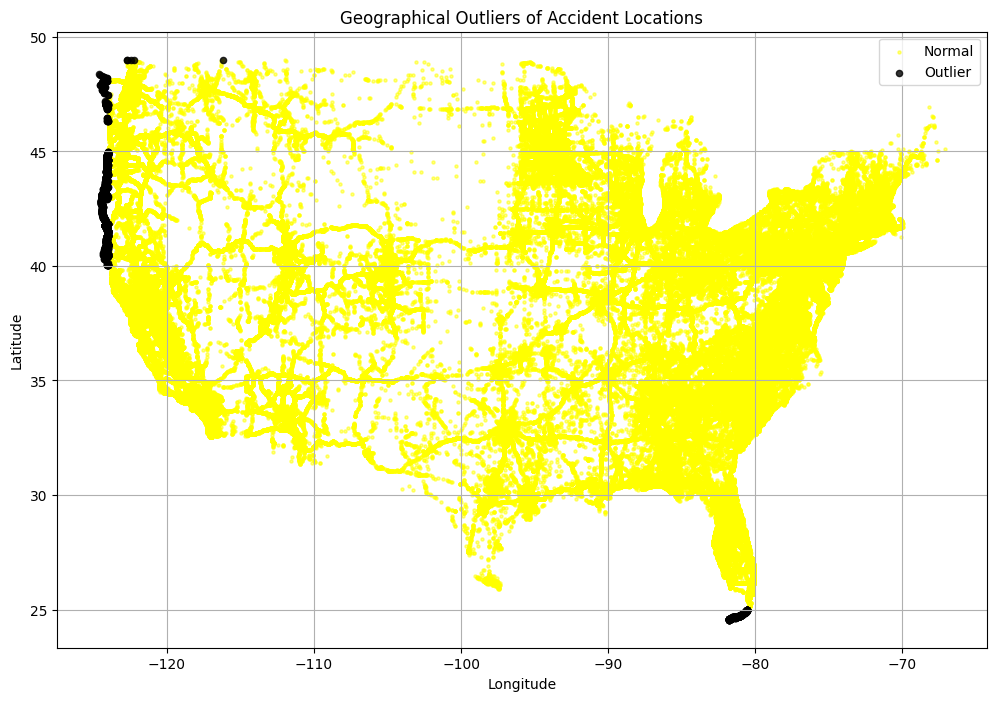

In [14]:
# how this works:
# Q1 is 1st quartile (چارک), Q3 is 3rd quartile
# calculates IQR for lat and lng (Q3-Q1)
# IQR shows spread in middle 50% of data (from Q1 to Q3)
# defines outlier threshold using IQRs
# rules:
  # Lower bound: Q1 - (1.5 * IQR)
  # Upper bound: Q3 + (1.5 * IQR)
''' Q1_Lat = df['Start_Lat'].quantile(0.25)
Q3_Lat = df['Start_Lat'].quantile(0.75)
IQR_Lat = Q3_Lat - Q1_Lat

Q1_Lng = df['Start_Lng'].quantile(0.25)
Q3_Lng = df['Start_Lng'].quantile(0.75)
IQR_Lng = Q3_Lng - Q1_Lng

outliers = (
    (df['Start_Lat'] < (Q1_Lat - 1.5* IQR_Lat)) |
    (df['Start_Lat'] > (Q3_Lat + 1.5* IQR_Lat)) |
    (df['Start_Lng'] < (Q1_Lng - 1.5* IQR_Lng)) |
    (df['Start_Lng'] > (Q3_Lng + 1.5* IQR_Lng))) '''

#-------------------------------------------------------------------------------

# defining min and max latitude adn longitude to detect outliers
us_bounds = {
    'lat_min': 25.0, 'lat_max': 49.0,
    'lng_min': -124.0, 'lng_max': -66.0
}

# create outliers based on us_bounds
outliers = (
    (df['Start_Lat'] < us_bounds['lat_min']) |
    (df['Start_Lat'] > us_bounds['lat_max']) |
    (df['Start_Lng'] < us_bounds['lng_min']) |
    (df['Start_Lng'] > us_bounds['lng_max'])
)



plt.figure(figsize=(12, 8))

# creating a scatter plot of non outliers in start lng and lat (yellows)
plt.scatter(df[~outliers]['Start_Lng'].to_numpy(),
            df[~outliers]['Start_Lat'].to_numpy(),
            color='yellow',
            alpha=0.5,
            s=5,
            label='Normal')

# creating a scatter plot of outliers in start lng and lat(blacks)
plt.scatter(df[outliers]['Start_Lng'].to_numpy(),
            df[outliers]['Start_Lat'].to_numpy(),
            color='black',
            alpha=0.8,
            s=20,
            label='Outlier')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Outliers of Accident Locations')
plt.legend()
plt.grid(True)
plt.show()

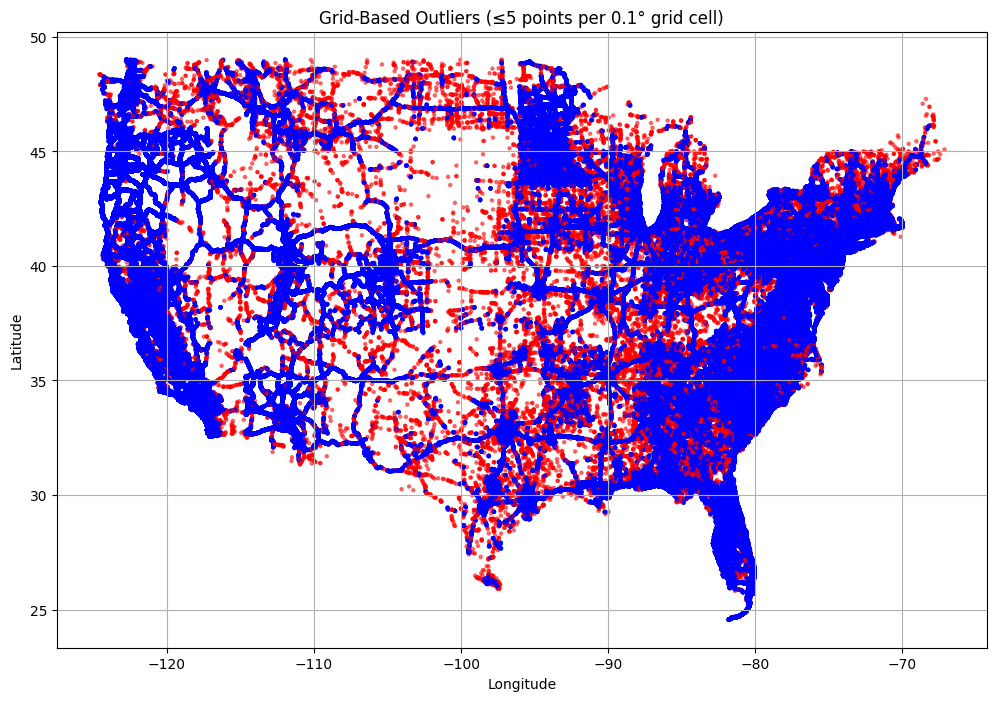

In [13]:
# Create grid bins
# multiplies lat/lng by 10 and rounds to create a grid cell
# example : (34.0652N, -118.84569W) ---> (340, -1180)
df['lat_bin'] = (df['Start_Lat'] * 10).round()
df['lng_bin'] = (df['Start_Lng'] * 10).round()

# counting how many points are in each unique grid cell
# less counts = potential outlier
grid_counts = df.groupby(['lat_bin', 'lng_bin']).size().rename('count')

# adds 'counts' to the original dataset and labels those with <=5 pounts as True(outlier)
df = df.merge(grid_counts.reset_index(), on=['lat_bin', 'lng_bin'])
df['outlier'] = df['count'] <= 5

# visualization (red=outliers)
plt.figure(figsize=(12, 8))
plt.scatter(
    df['Start_Lng'].to_numpy(),
    df['Start_Lat'].to_numpy(),
    c=df['outlier'].to_numpy(),
    cmap='bwr',
    s=5,
    alpha=0.5
)
plt.title('Grid-Based Outliers (≤5 points per 0.1° grid cell)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()